# Creation of all plots in paper
This notebook do the following:
1. sync all files, stack all runs, save references
2. non-linear scale for chameleon
3. matter power spectrum


## Syncing
File are copied from `koios:/home/users/vrastil/GIT/FastSim/jobs/output/report/` and saved to `/home/michal/Documents/GIT/FastSim/report/clanek/`

In [1]:
import os
os.system("gnome-terminal -e 'bash -c \"/home/users/vrastil/GIT/FastSim/jobs/sync.sh\" '")

0

## Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simpy.power as pwr
import simpy.data as dt
import simpy.plot as pt
import simpy.utils as ut
from simpy import struct
import simpy.database as database

from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to the database

In [3]:
db = database.connect_db()["fastsim"]

Password:········
Successfully conected to the database.


In [58]:
print "Num of deleted documents: ", db.data.delete_many({'type' : 'stack_info'}).deleted_count

Num of deleted documents:  30


## Stack everything
Look for new runs

In [4]:
# local
# in_dir = '/home/michal/Documents/GIT/FastSim/jobs/output/'
# out_dir = '/home/michal/Documents/GIT/FastSim/report/clanek/'

# koios
in_dir = '/home/users/vrastil/GIT/FastSim/jobs/output/'
out_dir = '/home/users/vrastil/GIT/FastSim/jobs/output/report/'

In [5]:
# database.add_many_sim_data(in_dir, db)
database.print_db_info(db)

There are in total 4554 number of simulations.
CHI (1607):
	Nm = 256, NM = 512, Np = 256, L = 1000, phi = 1.0E-05, n = 0.5 (non-linear), num = 77
	Nm = 256, NM = 512, Np = 256, L = 1000, phi = 1.0E-05, n = 0.5 (linear), num = 101
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-06, n = 0.5 (linear), num = 100
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-06, n = 0.5 (non-linear), num = 96
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.1 (linear), num = 99
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.1 (non-linear), num = 100
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.5 (linear), num = 120
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.5 (non-linear), num = 102
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.7 (linear), num = 100
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-05, n = 0.7 (non-linear), num = 99
	Nm = 256, NM = 512, Np = 256, L = 2000, phi = 1.0E-04, n = 0.5 (linear), num = 100
	

Stack everything (according tp `query`)

In [7]:
# all approximations, files only
query = None
skip = None
rerun = None
stack_info = dt.stack_all(db, verbose=False, query=query, skip=skip, rerun=rerun)

Stacking group 30/30



## Non-linear scale for chameleon
1. Compton wavelength $\lambda_c$
2. chameleon field $\chi_a$
3. screening potential $\Phi_{a,scr}$
4. chameleon screening scale $k_{src}$

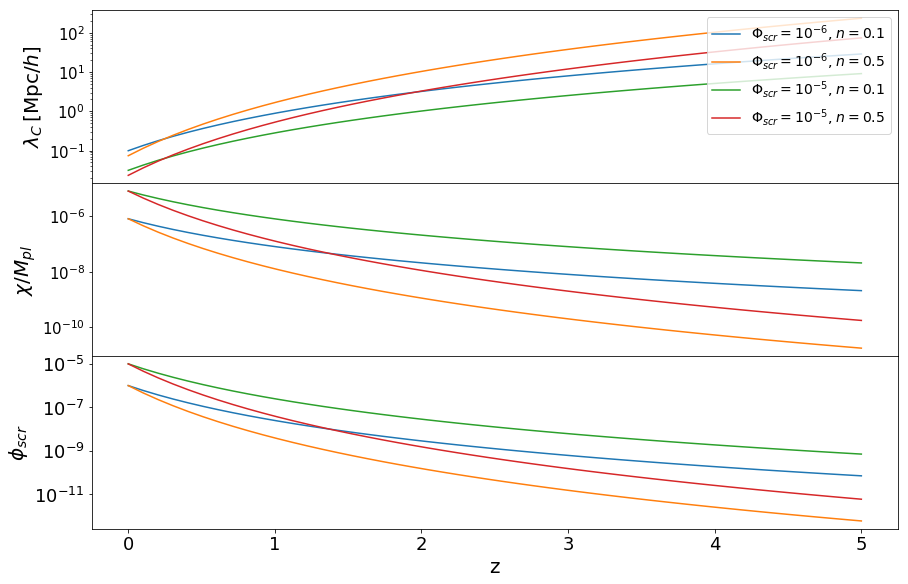

In [30]:
n = [0.1,0.5]
phi = [10**(-6), 10**(-5)]
dt.plot_chi_wave_pot(db, outdir=out_dir + "chi/", n=n, phi=phi, k_scr=False)

## Matter Power Spectrum
1. stack runs of the same approximations together (increase resolution range)
2. plot power spectrum at $z=0$ with all approximation, cut to see difference at small scales
3. plot power spectrum relative difference at different redshifts, cut to $k_{nq}/2$
4. plot power spectrum suppresion at three different scales
5. plot slope of the power spectrum

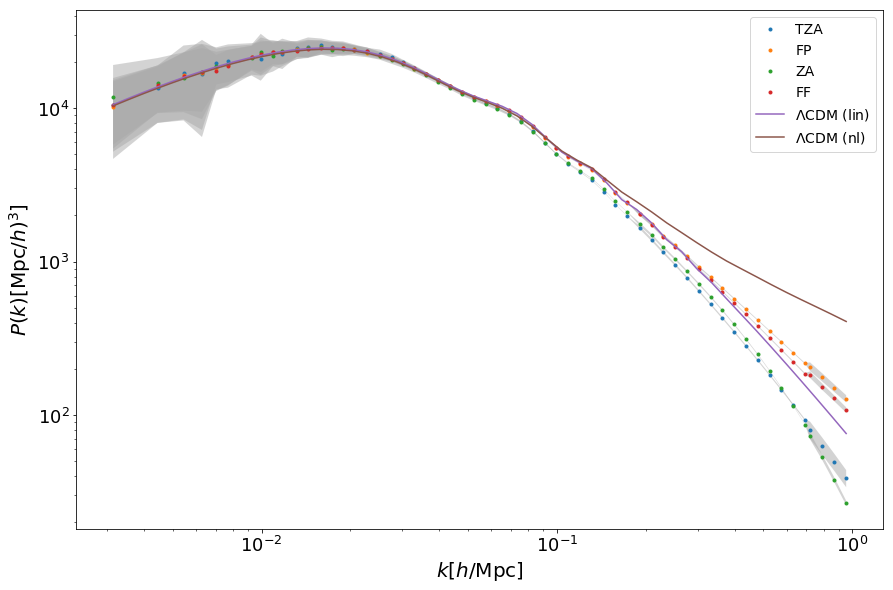

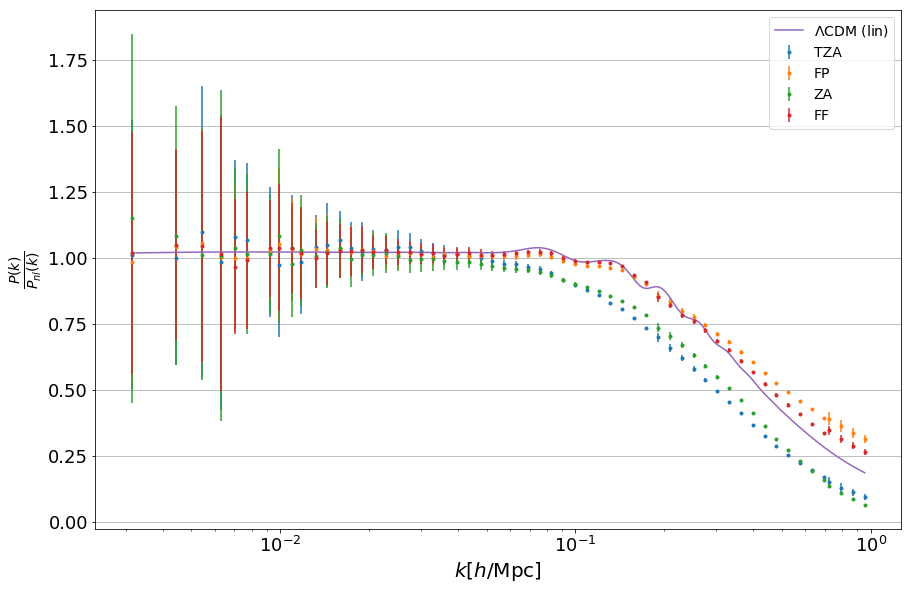

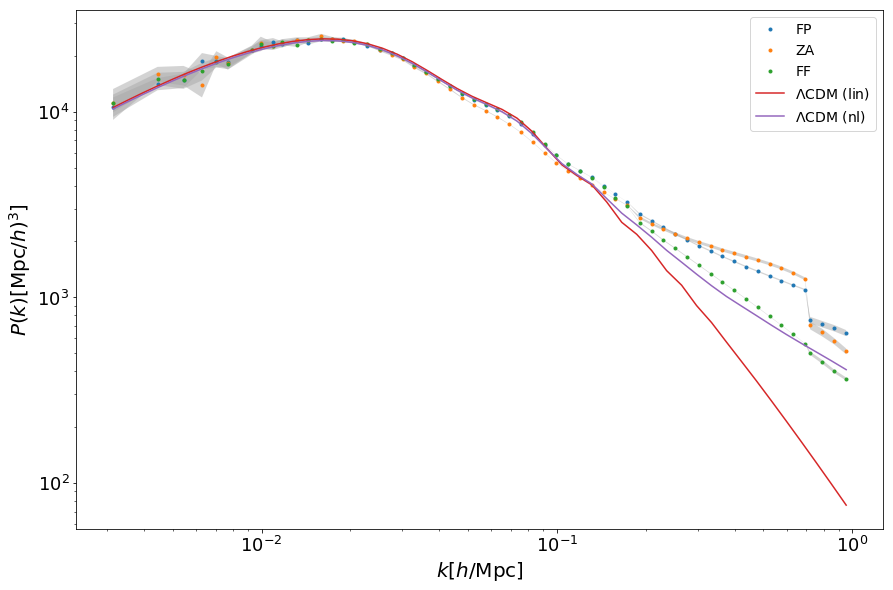

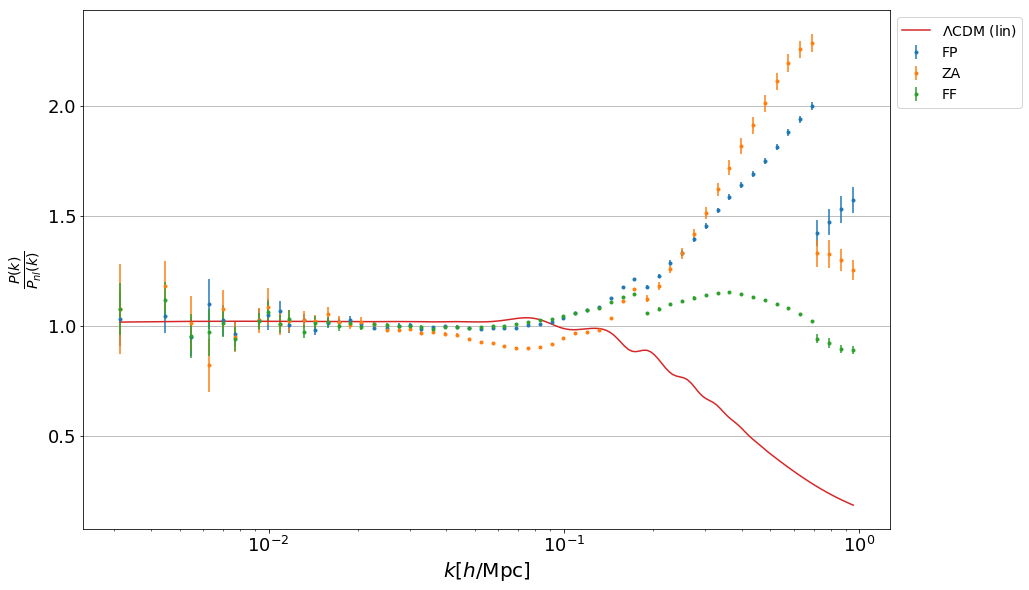

In [31]:
dt.get_plot_mlt_pk_broad(db, out_dir=out_dir + 'pwr_spec/', z=0)
dt.get_plot_mlt_pk_broad(db, out_dir=out_dir + 'pwr_spec/', z=0, pk_type='vel')

**
FF
**


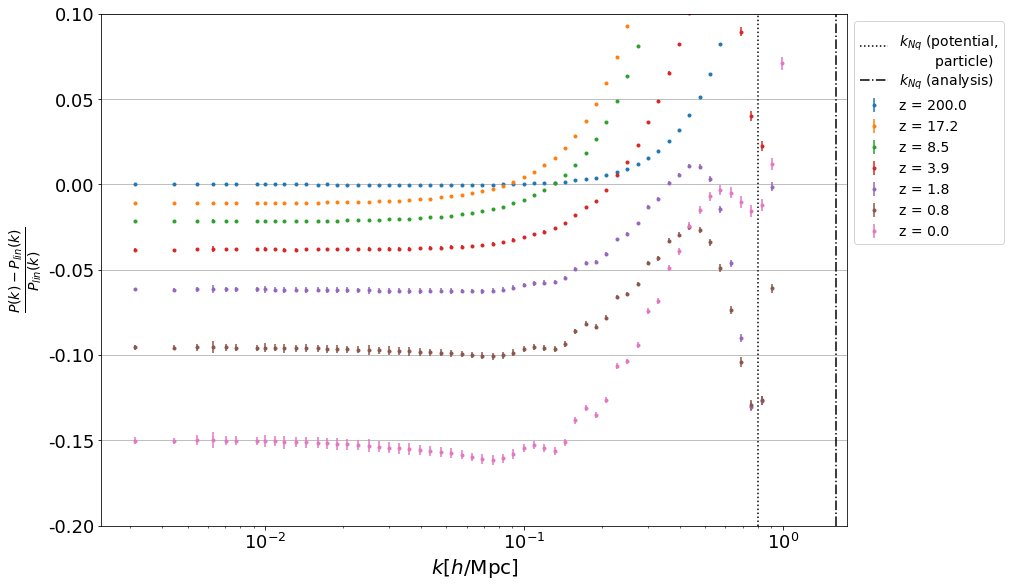

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


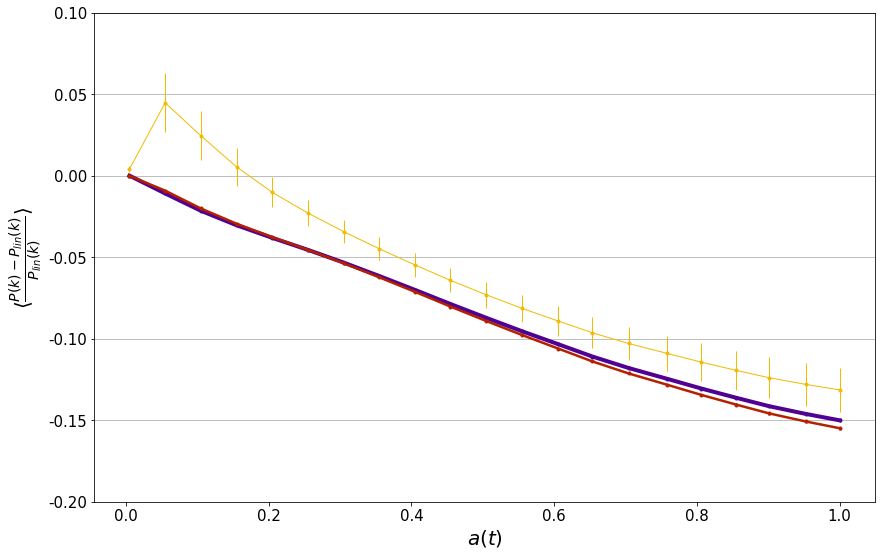

**
FP
**


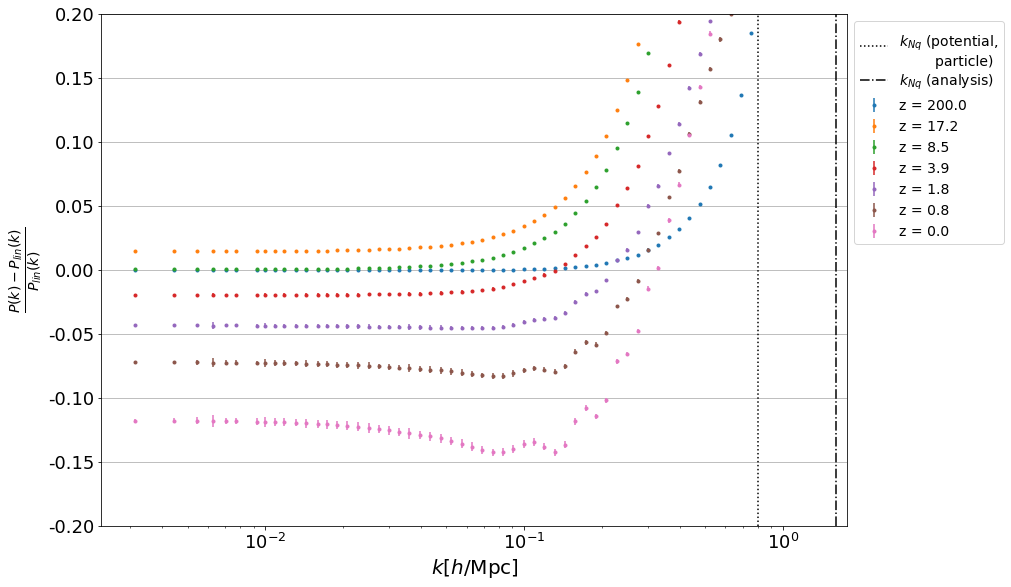

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


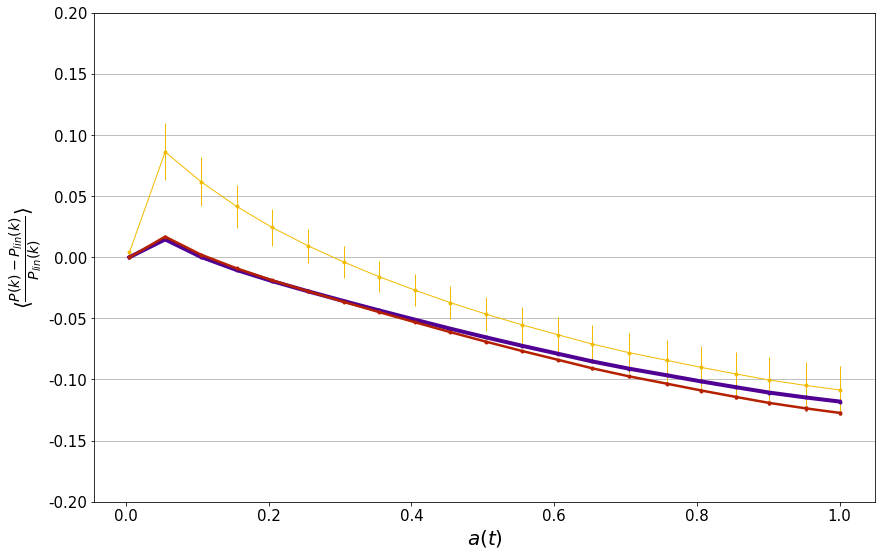

***
TZA
***


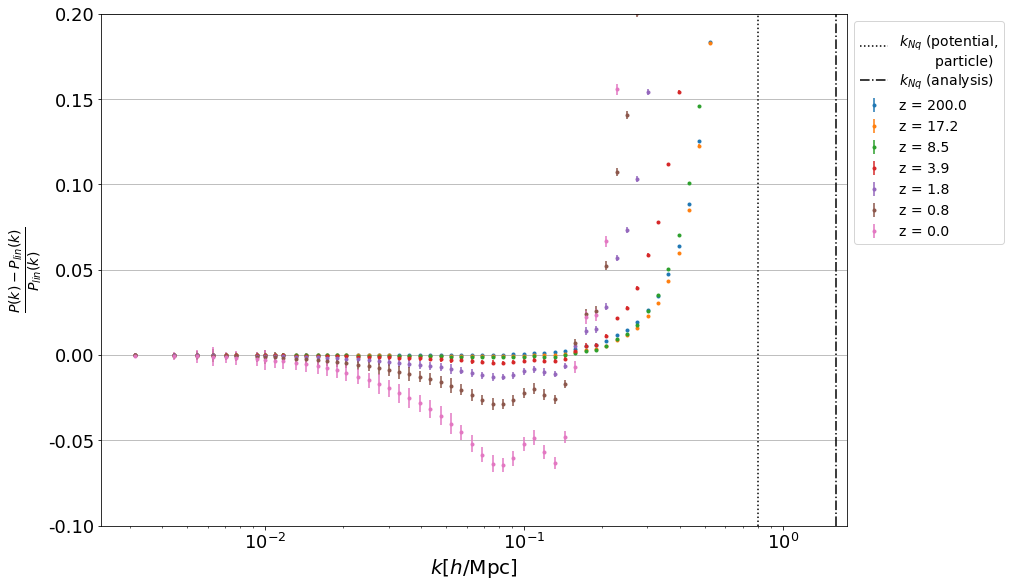

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


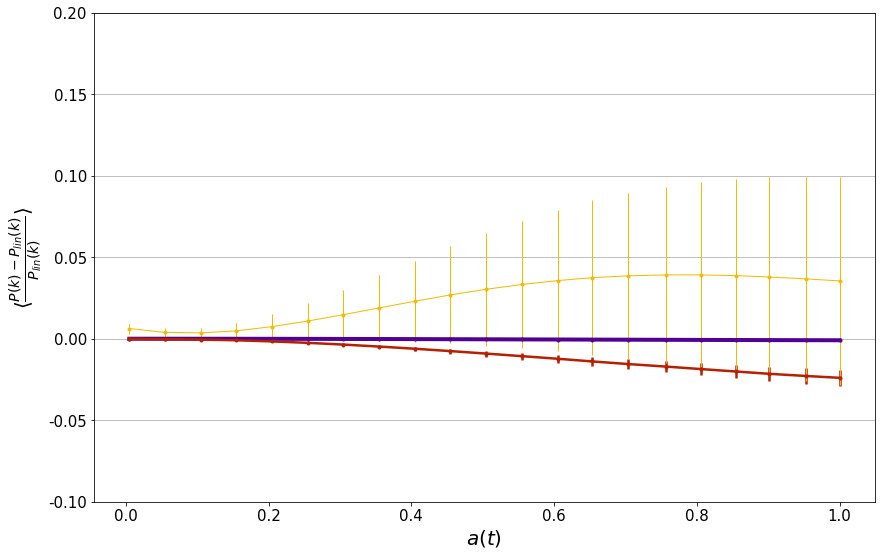

**
ZA
**


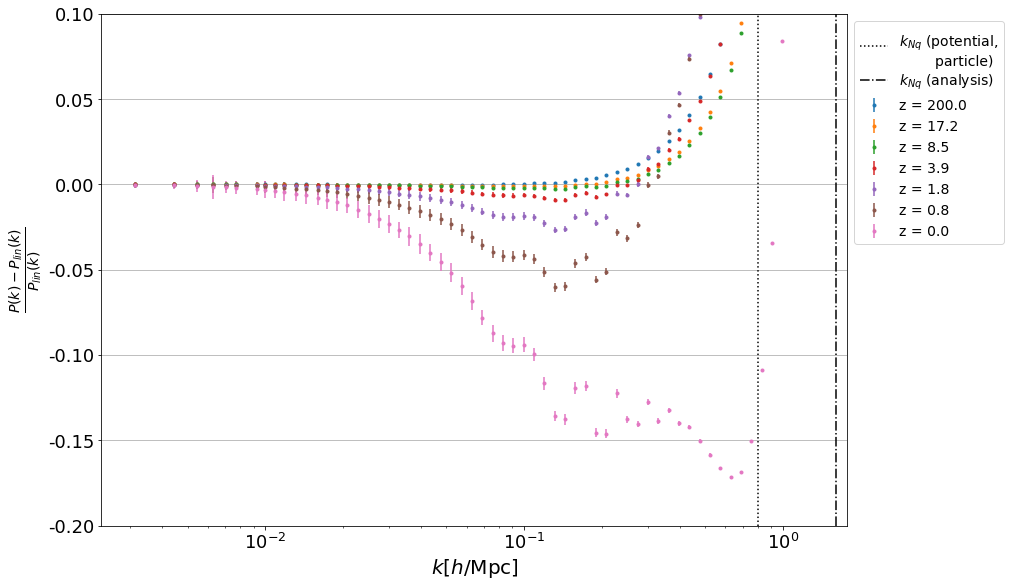

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


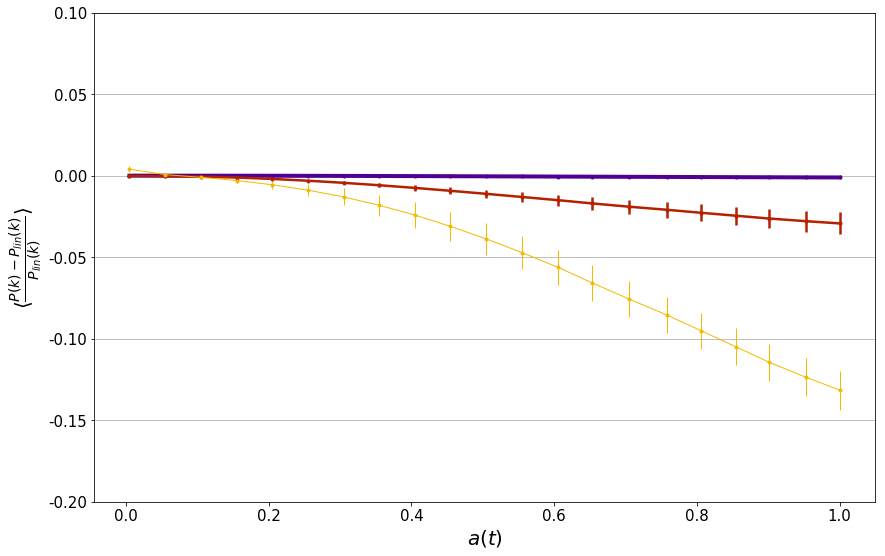

In [32]:
query = None
stack_infos = dt.get_stack_infos(db, box_size=2000, mesh_num_pwr=1024, query=query)
for stack_info in stack_infos:
    ut.print_info(stack_info.app)
    zs, data_list = stack_info.get_zs_data("pwr_diff", '*input*')
    a = [1./(z+1.) for z in zs if z != 'init']
    dt.correct_tza(stack_info, data_list)
    supp = dt.load_k_supp(data_list, stack_info.k_nyquist["particle"], a_sim_info=stack_info, a=a)
    
    # plots -- diff, supp 
    pt.plot_pwr_spec_diff_from_data(data_list, zs, stack_info, out_dir=out_dir + 'pwr_spec/', show_scales=False,
                                 ext_title='init', show=True, add_app=True, max_nyquist=True)
    
    
    pt.plot_supp_lms(supp, a, stack_info, out_dir=out_dir + 'pwr_spec/', show=True, add_app=True, scale_in_leg=False)

## Effective redshift
1. get $a_{eff}$ for each (non-chi) stack_info
2. plot both $P(k)$--type and $\sigma_R$--type
3. plot growth rate $f$

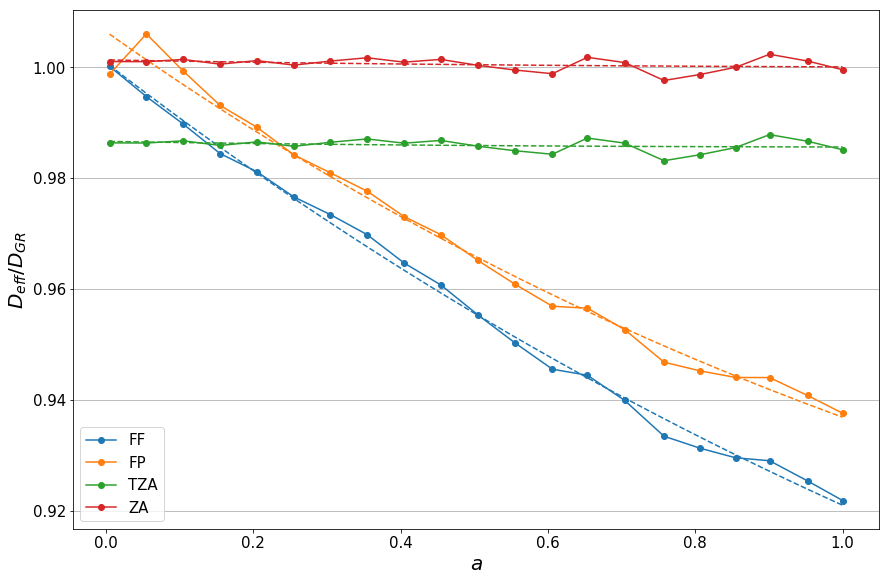

*****************
Growth rate: 'Pk'
*****************


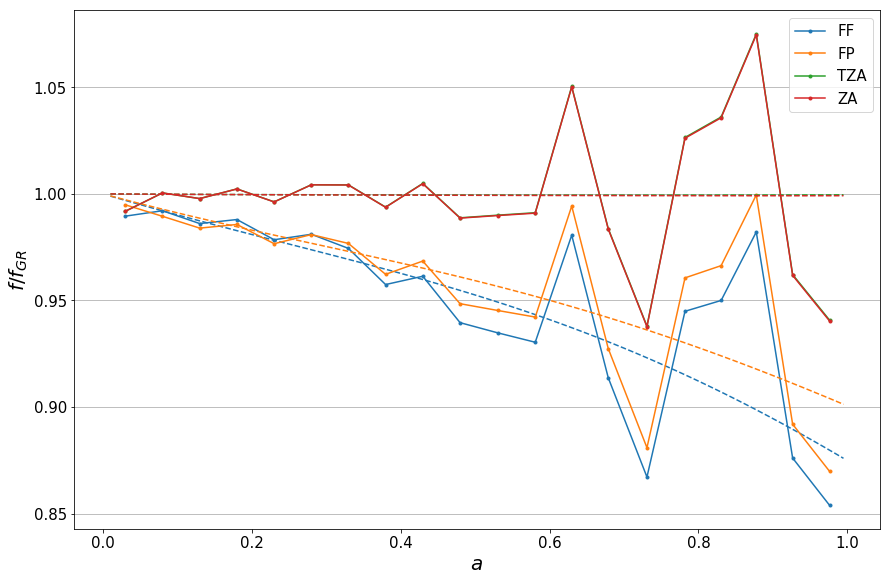

In [34]:
query = {'app' : {"$in" : ['TZA', 'ZA']}, 'type' : 'stack_info'}
query = None
non_chi_stack_infos = dt.get_stack_infos(db, box_size=2000, mesh_num_pwr=1024, query=query)
for stack_info in non_chi_stack_infos:
    dt.load_a_eff(stack_info)

pt.plot_eff_time(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="Pk", show=True)
pt.plot_eff_growth_rate(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="Pk", show=True)

## Non-linear matter power spectrum
1. stack simulations across different runs (different box sizes)
2. use effective redshift
3. plot power spectrum difference
4. plot power spectrum map
5. amplitude of non-linear power spectrum

/home/users/vrastil/GIT/FastSim/simpy/data.py:171: RuntimeWarning: invalid value encountered in subtract
  data_array_new[:, 1] -= Pk_init


***
TZA
***


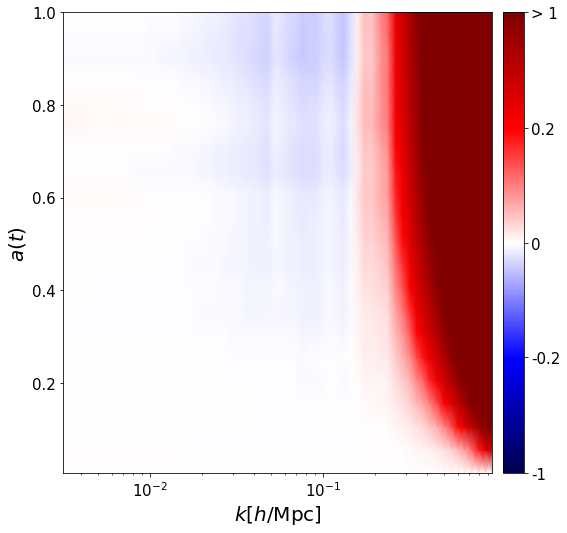

**
FP
**


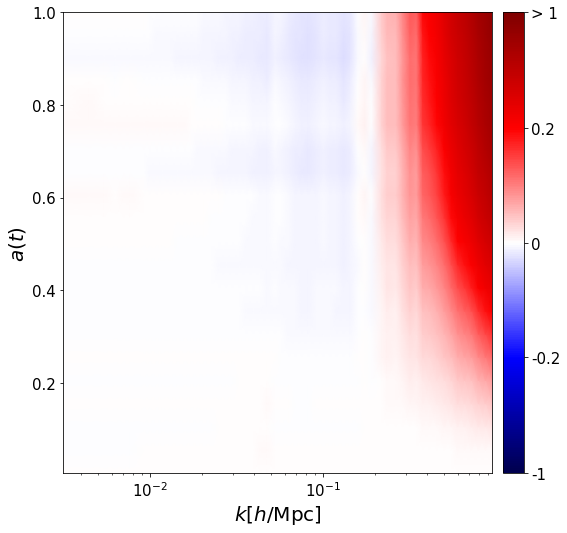

**
ZA
**


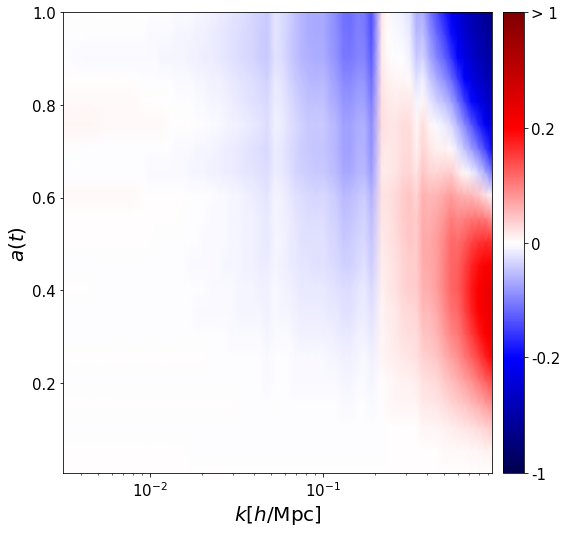

**
FF
**


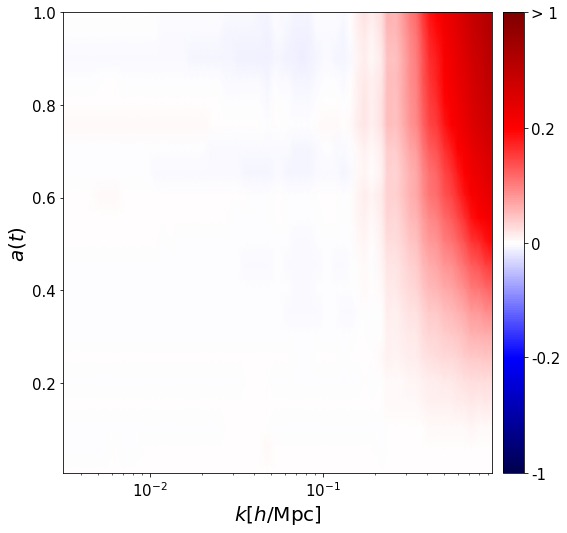

In [35]:
# non_chi_stack_infos = results.get_subfiles(NM=1024,  app_not='CHI', app='TZA')
# for si in non_chi_stack_infos:
#     print(si.info_tr())
#     zs, data_array = dt.transform_supp_data_to_z_eff(si)
#     dt.correct_tza(si, data_array)
#     pt.plot_pwr_spec_diff_from_data(data_array, zs, si, show_scales=False, save=False, show=True, use_z_eff=True)
#     pt.plot_pwr_spec_diff_map_from_data(data_array, zs, si, save=False, show=True, use_z_eff=True)
dt.get_plot_mlt_pk_diff_broad(db, out_dir=out_dir + 'pwr_spec_nl/', plot_diff=False)

In [36]:
# non_chi_stack_infos = dt.get_stack_infos(db, box_size=500, mesh_num_pwr=1024)

# for si in non_chi_stack_infos:
#     dt.get_pk_nl_amp(si)
    
# pt.plot_pwr_spec_nl_amp(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec_nl/', show=True)

## Correlation function
1. simple correlation function (all approximation)
2. correlation function difference (all approximation)
3. correlation function peak amplitude and location (effective time)

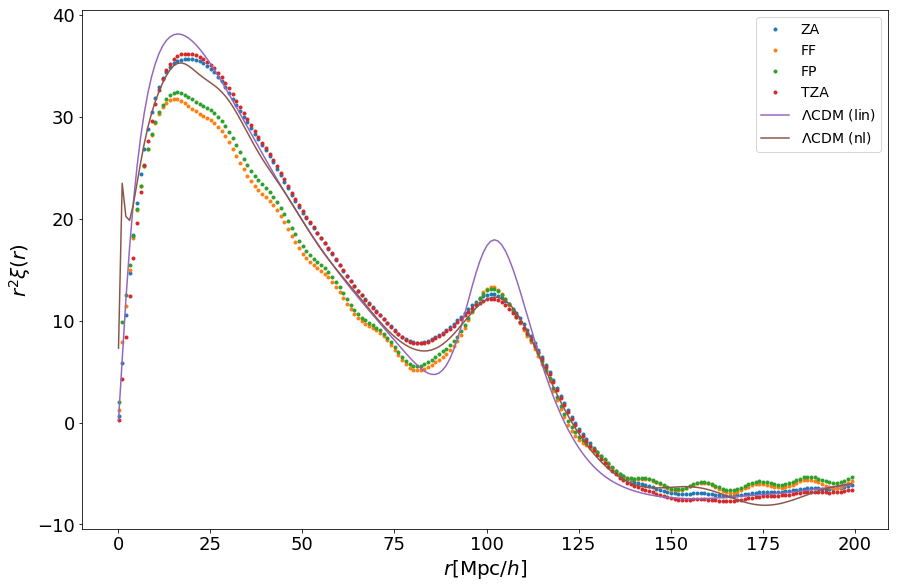

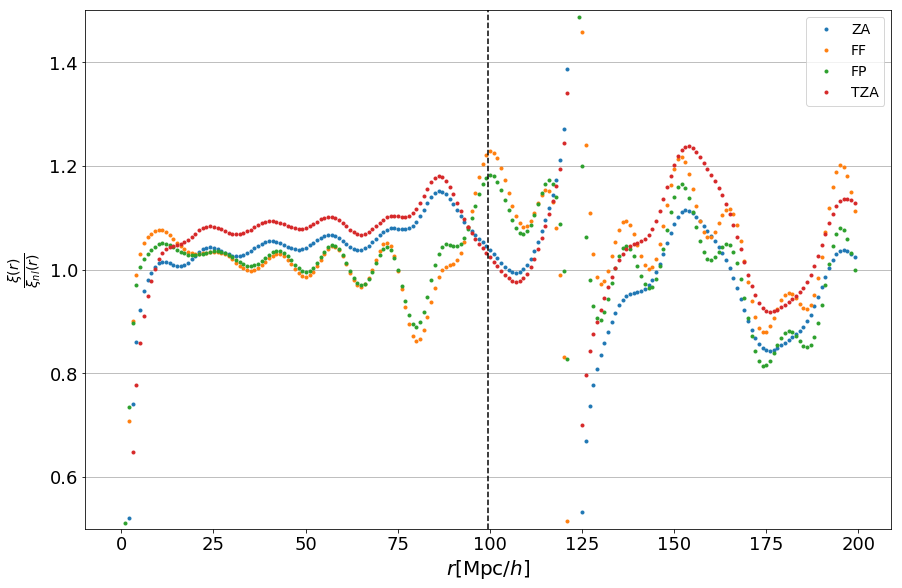

In [37]:
non_chi_stack_infos = dt.get_stack_infos(db, box_size=2000, mesh_num_pwr=1024)
dt.corr_func_comp_plot(db, {}, sim_infos=non_chi_stack_infos, outdir=out_dir + 'corr_func/', z=0)

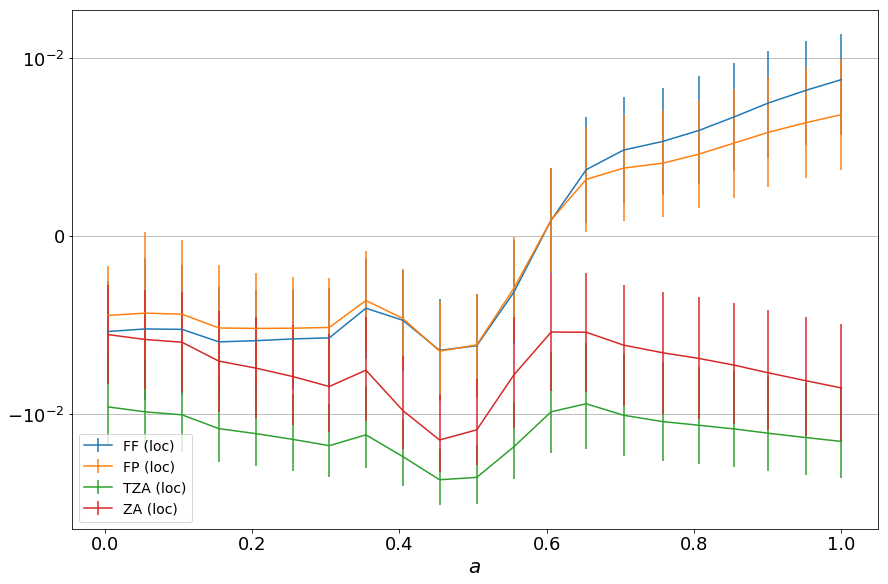

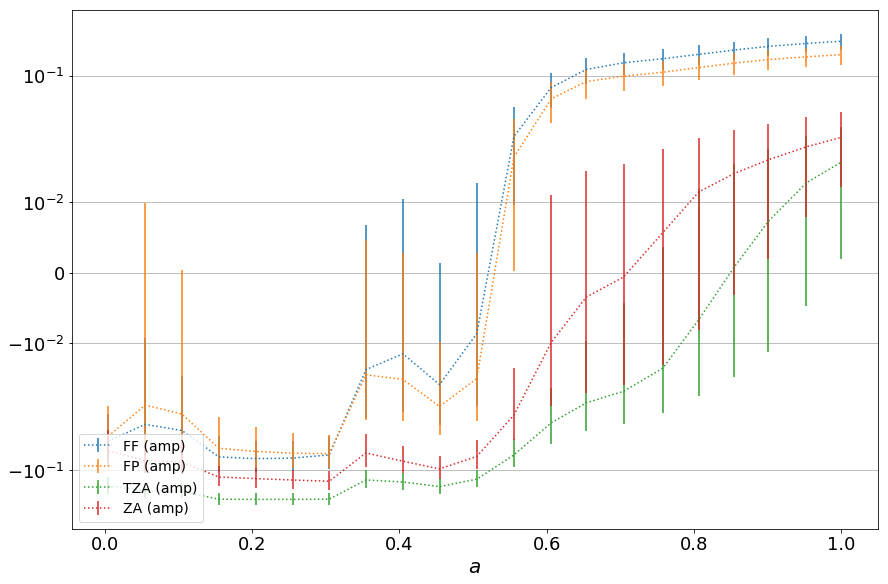

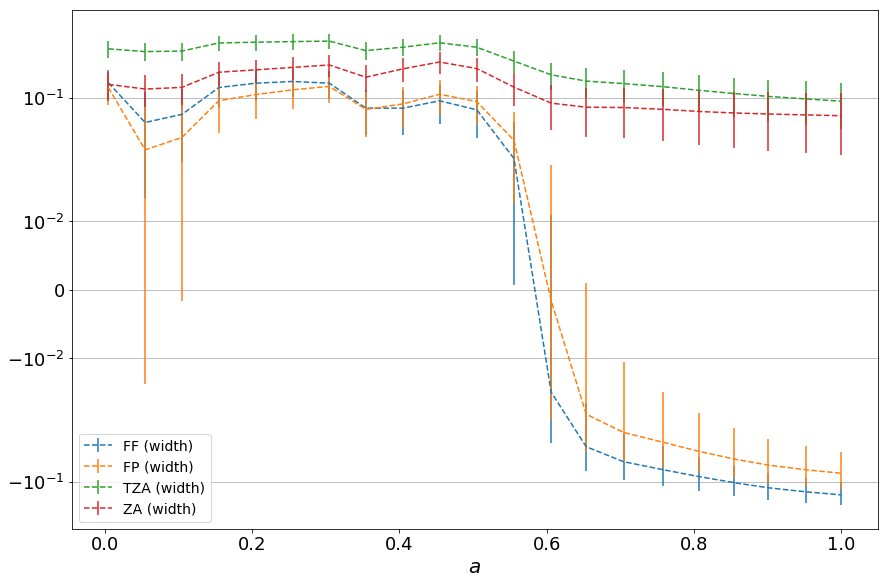

In [38]:
non_chi_stack_infos = dt.get_stack_infos(db, box_size=2000, mesh_num_pwr=1024)
dt.corr_func_comp_plot_peak(db, {}, sim_infos=non_chi_stack_infos, outdir=out_dir + 'corr_func/', plot_all=False)

## Chameleon results
1. effect of simulation resolution on resulting power spectrum
2. growth of structures on different scales (comparison with FPA)
3. compare different chameleon parameters (mainly through BAO peak)

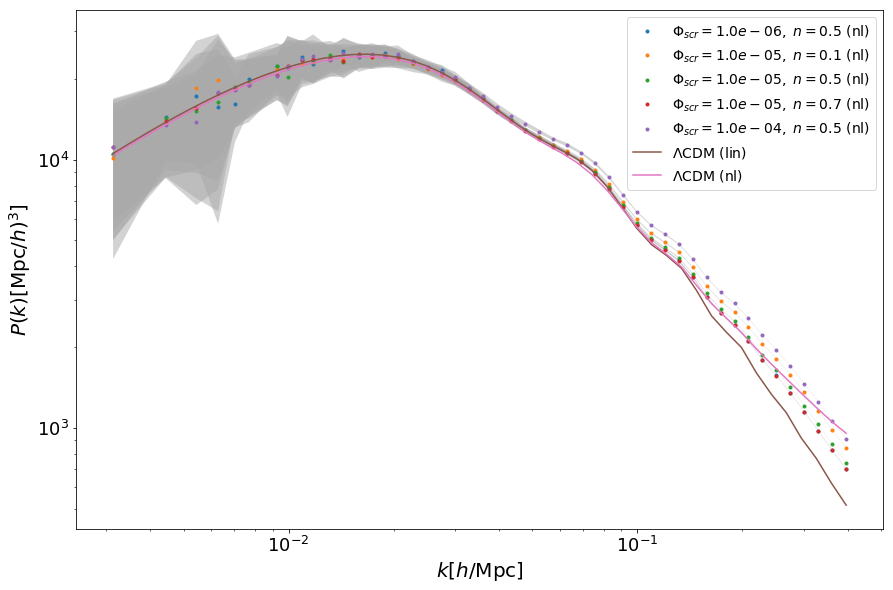

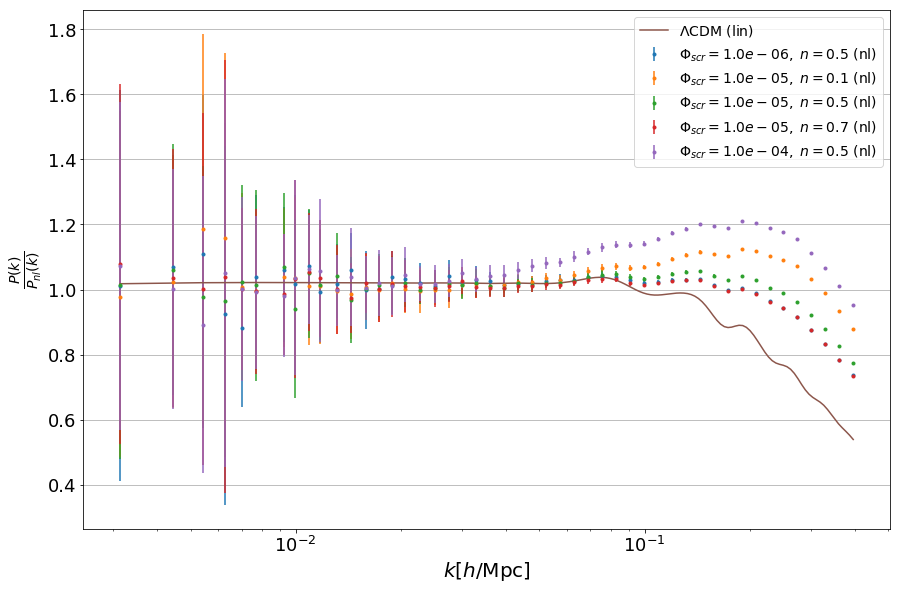

In [6]:
# non-linear
query = {'app' : 'CHI', 'type' : 'stack_info'}
chi_opt = {'linear' : False}
chi_stack_infos = dt.get_stack_infos(db, query=query, chi_opt=chi_opt, mesh_num=256, box_size=2000)    
dt.plot_pwr_spec_comparison_si(chi_stack_infos, out_dir=out_dir + 'chi/', z=0, show=True)

Phi =  1e-05 	n =  0.5


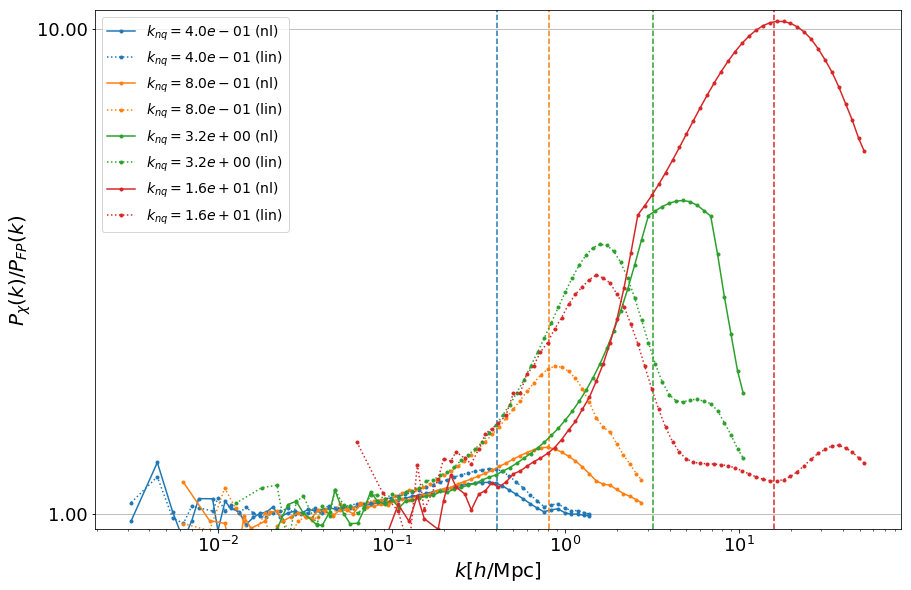

******************************************
Relative chameleon power spectrum, z = 0.0
******************************************


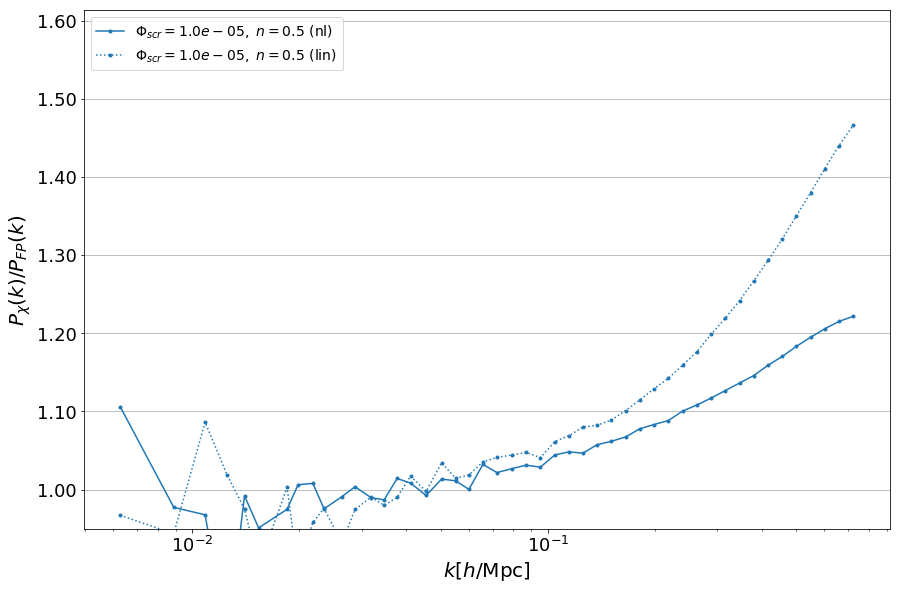

******************************************
Relative chameleon power spectrum, z = 0.0
******************************************


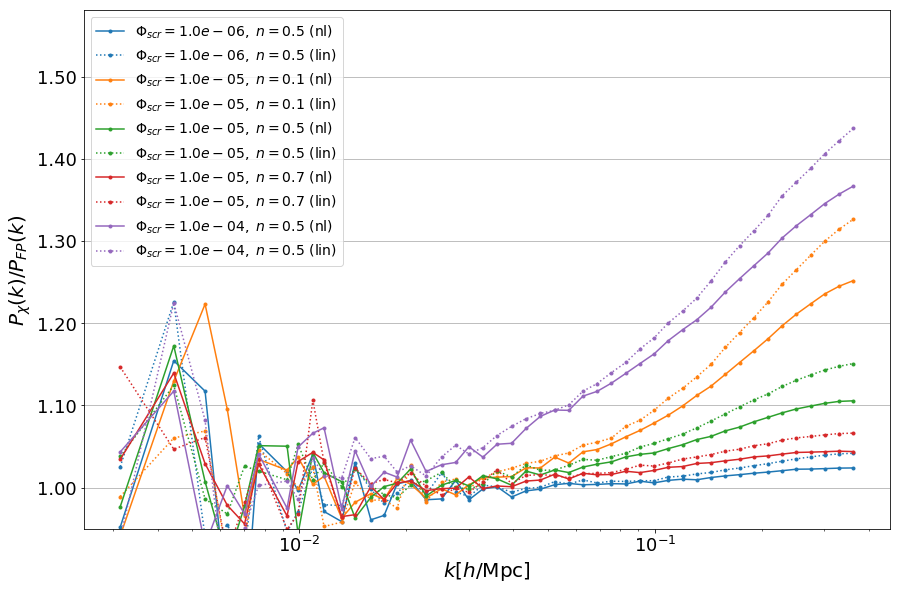

In [7]:
dt.compare_chi_res(db, out_dir=out_dir + 'chi/')
dt.compare_chi_fp(db, out_dir=out_dir + 'chi/', mesh_num=256, z=0)

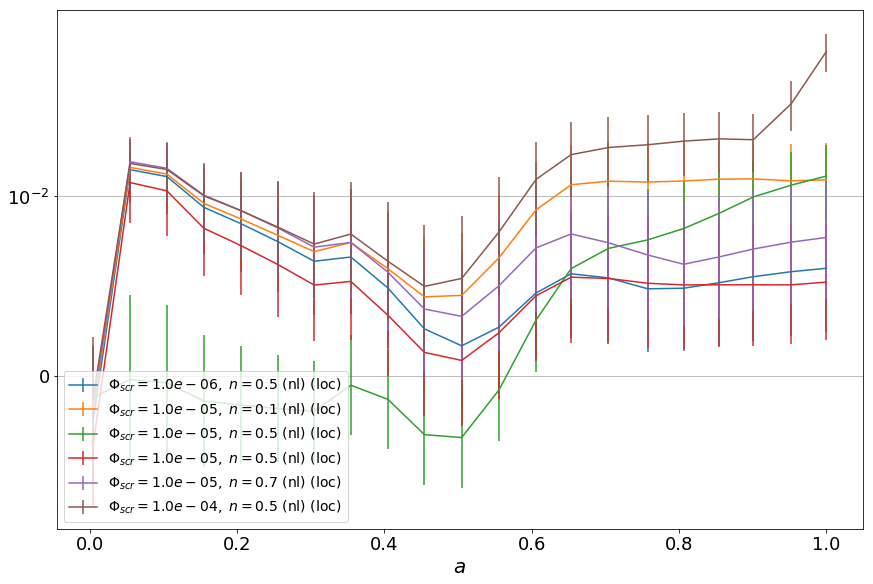

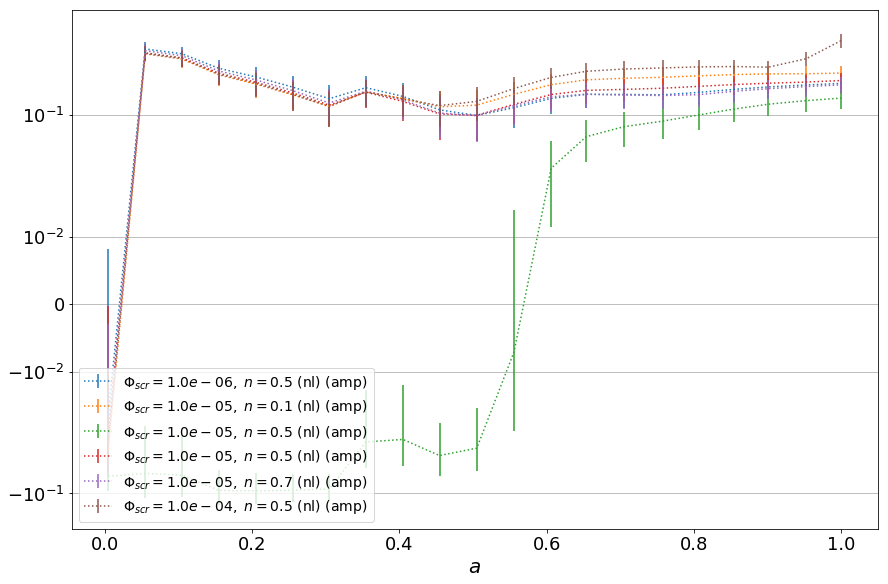

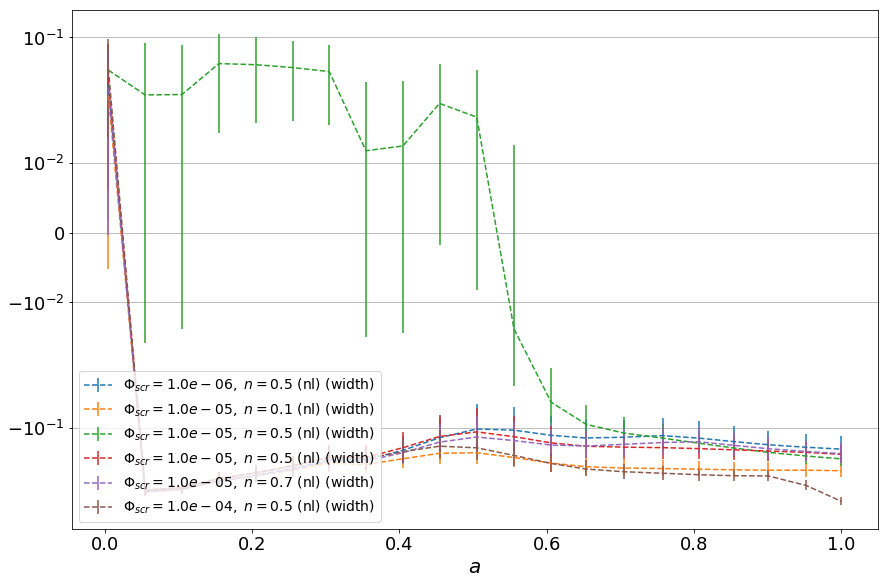

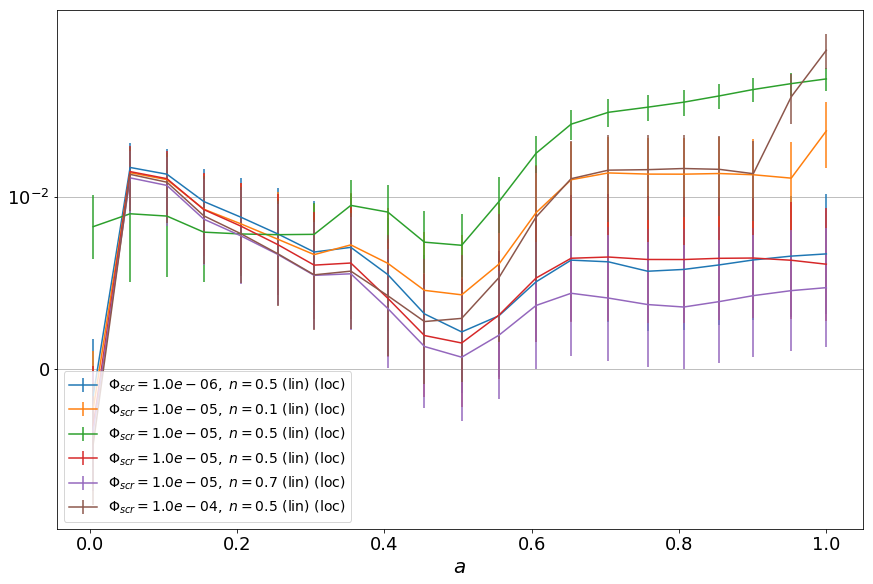

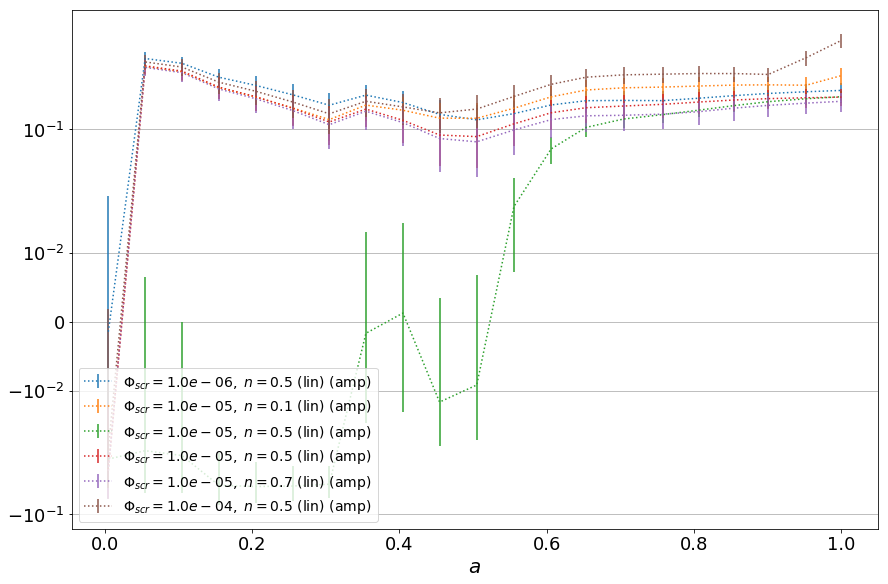

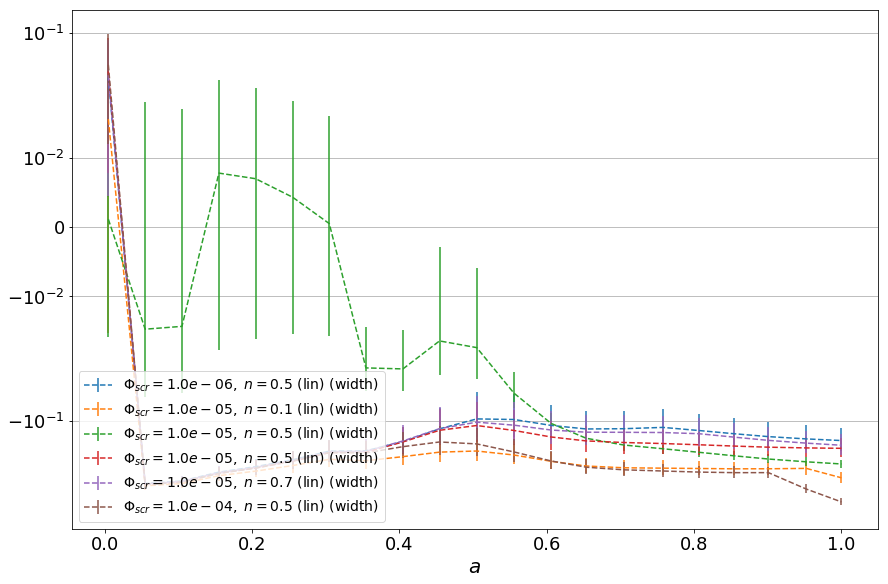

In [9]:
query = {'app' : 'CHI', 'type' : 'stack_info'}

# non-linear
chi_opt = {'linear' : False}
chi_stack_infos = dt.get_stack_infos(db, query=query, chi_opt=chi_opt, mesh_num=256)
dt.corr_func_comp_plot_peak(db, None, sim_infos=chi_stack_infos, outdir=out_dir + 'chi/nl_', plot_all=False)

# linear
chi_opt = {'linear' : True}
chi_stack_infos = dt.get_stack_infos(db, query=query, chi_opt=chi_opt, mesh_num=256)
dt.corr_func_comp_plot_peak(db, None, sim_infos=chi_stack_infos, outdir=out_dir + 'chi/lin_', plot_all=False)

## Direct comparison with FPA

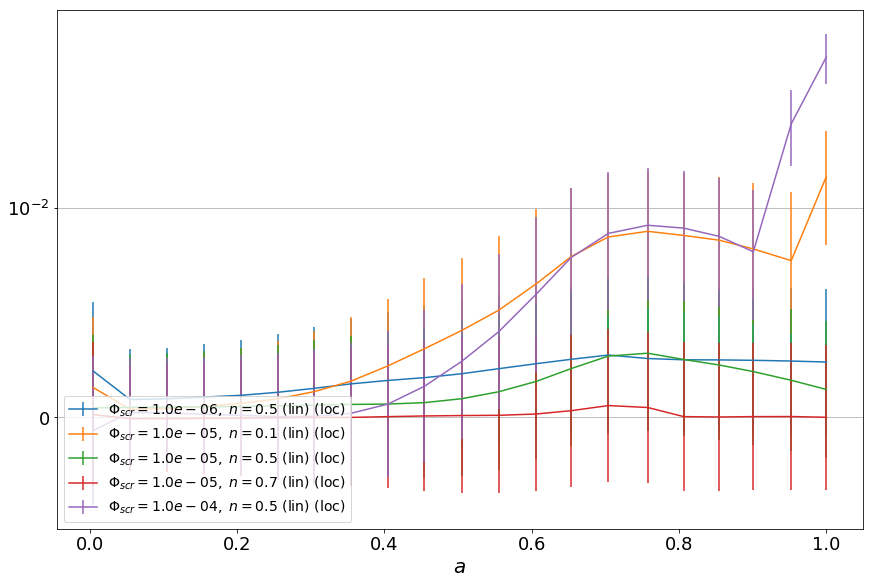

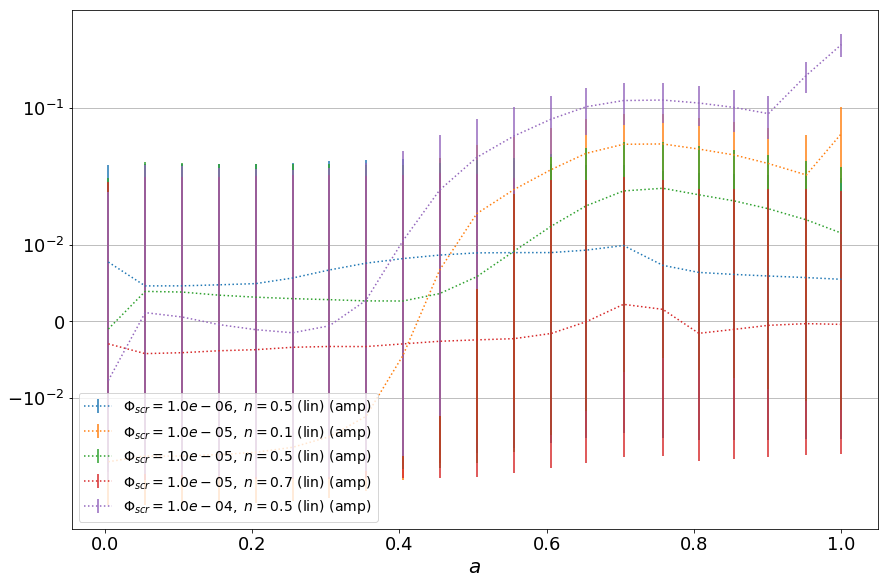

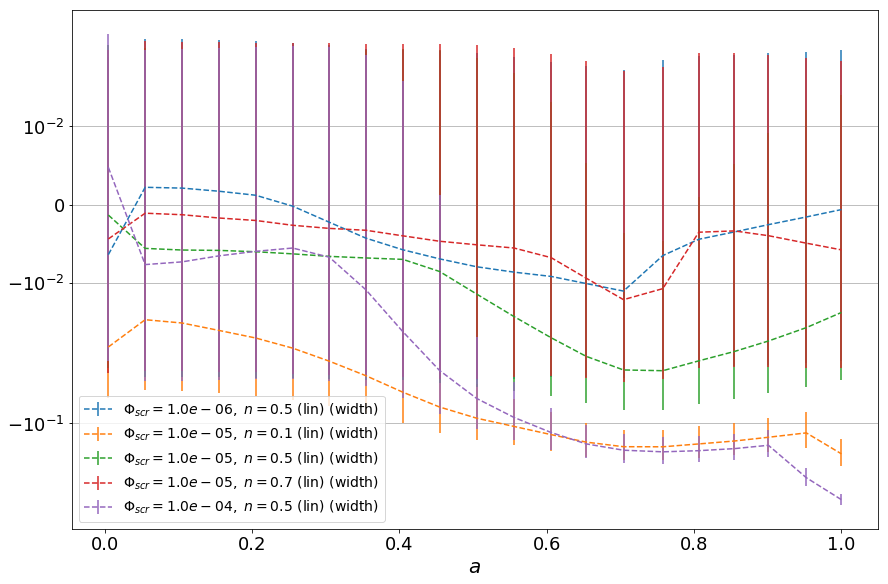

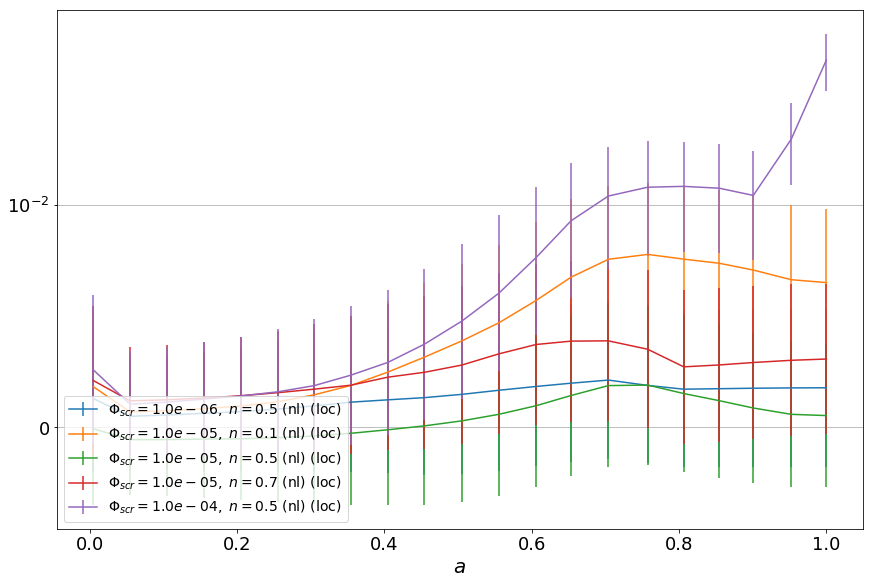

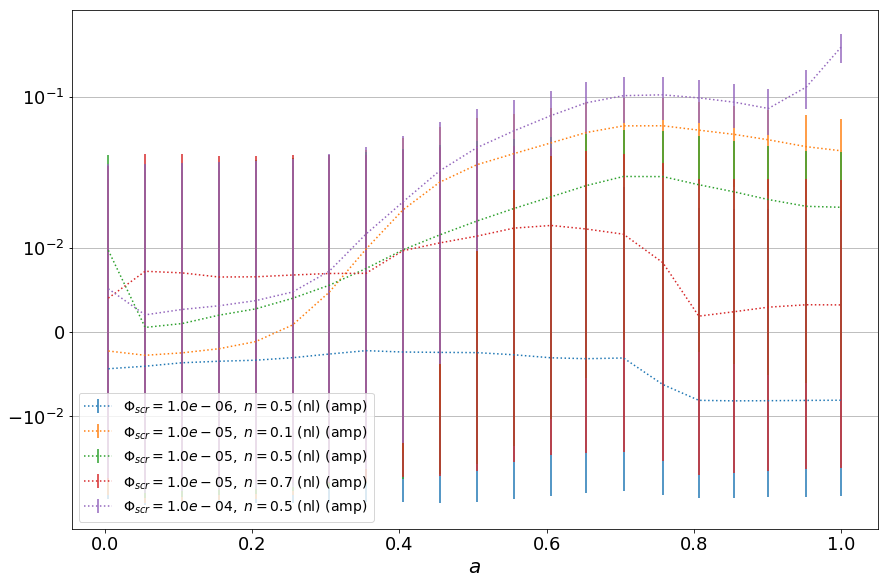

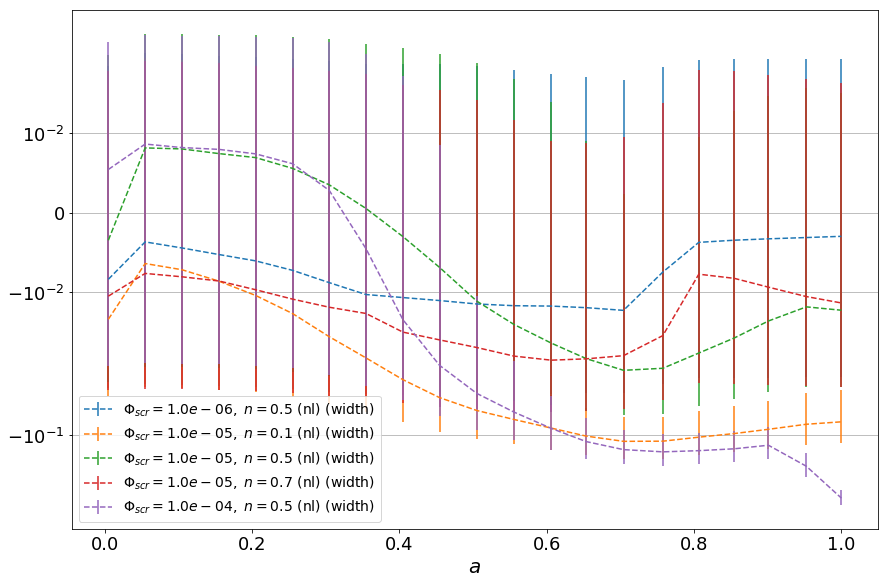

In [10]:
dt.corr_func_chi_fp_plot_peak(db, out_dir=out_dir + "chi/lin", mesh_num=256, chi_opt={'linear' : True})
dt.corr_func_chi_fp_plot_peak(db, out_dir=out_dir + "chi/nl", mesh_num=256, chi_opt={'linear' : False})

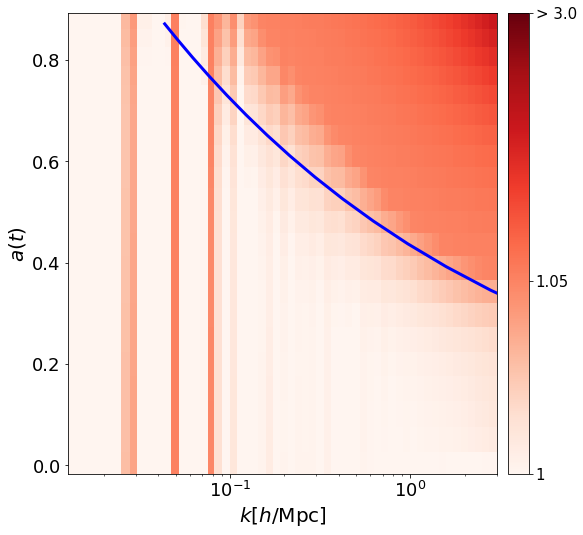

In [13]:
chi_info = dt.get_stack_infos(db, 
            query={'app' : 'CHI', 'type' : 'stack_info'},
            chi_opt={'linear' : False, 'n' : 0.5, 'phi' : 1e-5},
            mesh_num=512, box_size=500
)[0]

fp_info = dt.get_stack_infos(db, 
            query={'app' : 'FP', 'type' : 'stack_info'},
            mesh_num=512, box_size=500
)[0]

dt.compare_chi_fp_map(chi_info, fp_info, in_dir=in_dir, out_dir=out_dir + "chi/")